In [10]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
!pip install -q langchain pypdf sentence-transformers chromadb openai langchain_community datasets
openai_api_key = ''
pth=''

# 1. Multi-Query Retriever


> 사용자의 단일 질문을 여러 개의 관련 질의로 확장하여 검색을 수행하는 기법

>원본 쿼리를 여러 변형 쿼리로 재구성(보통 LLM 활용)


> **적합한 상황**
- 모호하거나 복잡한 질문 처리
- 포괄적인 정보 수집이 필요한 경우
- 사용자 질문의 의도가 다양한 해석 가능성을 가질 때
- 다면적 측면을 가진 질문

In [4]:
# Build a sample vectorDB
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# Load blog post
loader = WebBaseLoader("https://github.com/microsoft/BitNet")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
model_name = "jhgan/ko-sbert-nli"
encode_kwargs = {'normalize_embeddings': True}
ko_embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    encode_kwargs=encode_kwargs
)

vectordb = Chroma.from_documents(documents=splits, embedding=ko_embedding)

<ipython-input-4-ade1f8a31071>:18: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  ko_embedding = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.chat_models import ChatOpenAI

question = "bitnet의 파라매터는 몇개야?"
llm = ChatOpenAI(temperature=0, openai_api_key = openai_api_key)
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

<ipython-input-5-c959abc2c9e1>:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0, openai_api_key = openai_api_key)


In [6]:
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

unique_docs = retriever_from_llm.get_relevant_documents(query=question)
len(unique_docs)



<ipython-input-6-f655e1e08de9>:7: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  unique_docs = retriever_from_llm.get_relevant_documents(query=question)
INFO:langchain.retrievers.multi_query:Generated queries: ['1. How many parameters does bitnet have?', '2. What is the total number of parameters in bitnet?', '3. Can you tell me the quantity of parameters in bitnet?']


9

'1. How many parameters does bitnet have?',

'2. What is the total number of parameters in bitnet?',

'3. Can you tell me the quantity of parameters in bitnet?'

3가지 쿼리가 재생성됨

# 2. Parent-document Retriever

> 문서의 계층적 구조를 활용하는 검색 방식으로 작은 청크를 검색한 후, 그 청크가 속한 더 큰 문맥(상위 문서)을 함께 반환

> 작은 단위로 문서를 인덱싱하되, 검색 시 그 상위 문서의 컨텍스트도 함께 제공

> **적합한 상황**
- 문서 간 관계나 계층 구조가 중요한 경우
- 법률 문서, 학술 논문 등 맥락이 중요한 도메인
- 문서의 특정 부분만으로는 완전한 이해가 어려운 주제
- 예: 법률 조항 해석, 논문의 특정 결과 해석


In [3]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings


In [25]:
loaders = [
    PyPDFLoader(pth  + "250122청년고용촉진특별위원회안건.pdf"),
    PyPDFLoader(pth  + "2025국내외경제전망.pdf")]
docs = []
for loader in loaders:
    docs.extend(loader.load_and_split())

In [4]:
model_name = "jhgan/ko-sbert-nli"
encode_kwargs = {'normalize_embeddings': True}
ko_embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    encode_kwargs=encode_kwargs
)

<ipython-input-4-07b97c86aaa8>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  ko_embedding = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [22]:
# 하위문서의 청크사이즈 설정
child_splitter = RecursiveCharacterTextSplitter(chunk_size=500)

vectorstore = Chroma(
    collection_name="full_documents", embedding_function=ko_embedding
)
# 리트리버
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

<ipython-input-22-bc8d95877a1b>:4: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [26]:
retriever.add_documents(docs, ids=None)

In [30]:
sub_docs = vectorstore.similarity_search("대학일자리플러스센터 내용")
print("글 길이: {}\n\n".format(len(sub_docs[0].page_content)))
print(sub_docs[0].page_content)

글 길이: 497


붙임 2 주요 청년고용정책 사업 개요1. 대학일자리플러스센터□(개요)청년에 가장 가까운 전달체계로 고용정책 홍보·안내및 참여를 지원하는 대학 내 취업 지원 인프라구축     * 전국 121개교 운영(수도권 45개교, 비수도권 76개교)ㅇ 재학·졸업생·지역 청년 대상 취업 상담,취업 지원 프로그램,기업 매칭,지역 청년 특화프로그램 등 제공□주요 내용ㅇ (재학생 맞춤형 고용서비스)1:1상담을 기반으로 저학년은 직업·진로 탐색과 설계,고학년은 취업활동계획 수립 및 훈련·일경험 연계 등 취업역량 향상 지원대  상 재학생 맞춤형 고용서비스 저학년 중심빌 드 업프 로 젝 트▪ 개인별 직업지도 및 진로탐색 역량제고 지원   * AI 기반 직업정보 제공, 1:1 심층상담 및 단기 일경험 등 지원  고학년 중심점 프 업 프 로 젝 트▪자기주도형(역량高): 취업스킬 향상 프로그램 지원 ▪서비스참여형(역량低): 훈련ㆍ일경험 기회 연계 -(운영현황)'24년 전국 53개교*대학일자리플러스센터에서 운영


In [31]:
retrieved_docs = retriever.get_relevant_documents("대학일자리플러스센터 내용")
print("글 길이: {}\n\n".format(len(retrieved_docs[0].page_content)))
print(retrieved_docs[0].page_content)


글 길이: 735


- 13 -
붙임 2 주요 청년고용정책 사업 개요1. 대학일자리플러스센터□(개요)청년에 가장 가까운 전달체계로 고용정책 홍보·안내및 참여를 지원하는 대학 내 취업 지원 인프라구축     * 전국 121개교 운영(수도권 45개교, 비수도권 76개교)ㅇ 재학·졸업생·지역 청년 대상 취업 상담,취업 지원 프로그램,기업 매칭,지역 청년 특화프로그램 등 제공□주요 내용ㅇ (재학생 맞춤형 고용서비스)1:1상담을 기반으로 저학년은 직업·진로 탐색과 설계,고학년은 취업활동계획 수립 및 훈련·일경험 연계 등 취업역량 향상 지원대  상 재학생 맞춤형 고용서비스 저학년 중심빌 드 업프 로 젝 트▪ 개인별 직업지도 및 진로탐색 역량제고 지원   * AI 기반 직업정보 제공, 1:1 심층상담 및 단기 일경험 등 지원  고학년 중심점 프 업 프 로 젝 트▪자기주도형(역량高): 취업스킬 향상 프로그램 지원 ▪서비스참여형(역량低): 훈련ㆍ일경험 기회 연계 -(운영현황)'24년 전국 53개교*대학일자리플러스센터에서 운영     * ▴(대학 종류별) 일반대학 47개교, 전문대학 6개교 ▴(지역별) 수도권 21개교, 비수도권 32개교ㅇ (고교생 맞춤형 고용서비스)직업계고 등 고교생 대상으로 진로탐색·설계,취업활동계획 수립,특화 취업프로그램 운영,기업 탐방,매칭 지원 등     * 20개교(직업계고 160여개 서비스) 운영 중□(지원 실적)진로·취업 기초 상담 약 130만건,각종 취업지원 프로그램 참여 약 115만건 등('23년)


load_and_split로 pdf 1페이지로 분할하였기 때문에 Parent-document가 pdf 1페이지의 모든 텍스트를 가짐(735)

## 2.1 본문의 Full_chunk가 너무 길때 인용구 추가


> 위 처럼 Parent-document의 청크가 클 경우엔 child_splitter 뿐만 아니라, parent_splitter도 함께 선언하여 청크 사이즈 조절

In [ ]:
# This text splitter is used to create the parent documents
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=450)
# This text splitter is used to create the child documents
# It should create documents smaller than the parent
child_splitter = RecursiveCharacterTextSplitter(chunk_size=150)
# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="split_parents", embedding_function=ko_embedding
)
# The storage layer for the parent documents
store = InMemoryStore()

In [41]:
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [42]:
retriever.add_documents(docs)
len(list(store.yield_keys()))

95

In [35]:
sub_docs = vectorstore.similarity_search("대학일자리플러스센터 내용")
print(sub_docs[0].page_content)
print("길이 : " , len(sub_docs[0].page_content))


붙임 2 주요 청년고용정책 사업 개요1. 대학일자리플러스센터□(개요)청년에 가장 가까운 전달체계로 고용정책 홍보·안내및 참여를 지원하는 대학 내 취업 지원 인프라구축     * 전국 121개교 운영(수도권 45개교, 비수도권 76개교)ㅇ 재학·졸업생·지역 청년 대상 취업 상담,취업 지원 프로그램,기업 매칭,지역 청년 특화프로그램 등 제공□주요 내용ㅇ
길이 :  196


In [36]:
retrieved_docs = retriever.get_relevant_documents("대학일자리플러스센터 내용")
print(retrieved_docs[0].page_content)
print("길이 : " ,len(retrieved_docs[0].page_content))

- 13 -
붙임 2 주요 청년고용정책 사업 개요1. 대학일자리플러스센터□(개요)청년에 가장 가까운 전달체계로 고용정책 홍보·안내및 참여를 지원하는 대학 내 취업 지원 인프라구축     * 전국 121개교 운영(수도권 45개교, 비수도권 76개교)ㅇ 재학·졸업생·지역 청년 대상 취업 상담,취업 지원 프로그램,기업 매칭,지역 청년 특화프로그램 등 제공□주요 내용ㅇ (재학생 맞춤형 고용서비스)1:1상담을 기반으로 저학년은 직업·진로 탐색과 설계,고학년은 취업활동계획 수립 및 훈련·일경험 연계 등 취업역량 향상 지원대  상 재학생 맞춤형 고용서비스 저학년 중심빌 드 업프 로 젝 트▪ 개인별 직업지도 및 진로탐색 역량제고 지원   * AI 기반 직업정보 제공, 1:1 심층상담 및 단기 일경험 등 지원  고학년 중심점 프 업 프 로 젝 트▪자기주도형(역량高): 취업스킬 향상 프로그램 지원 ▪서비스참여형(역량低): 훈련ㆍ일경험 기회 연계 -(운영현황)'24년 전국 53개교*대학일자리플러스센터에서 운영     * ▴(대학 종류별) 일반대학 47개교, 전문대학 6개교 ▴(지역별) 수도권 21개교, 비수도권 32개교ㅇ (고교생 맞춤형 고용서비스)직업계고 등 고교생 대상으로 진로탐색·설계,취업활동계획 수립,특화 취업프로그램 운영,기업 탐방,매칭 지원 등     * 20개교(직업계고 160여개 서비스) 운영 중□(지원 실적)진로·취업 기초 상담 약 130만건,각종 취업지원 프로그램 참여 약 115만건 등('23년)
길이 :  735


# 3. Self-querying

> 사용자의 질문을 자동으로 구조화된 쿼리로 변환하여 문서의 메타데이터 필터링과 함께 검색을 수행하는 방식

> 질문을 분석하여 검색어와 메타데이터 필터를 자동으로 생성

> **적합한 상황**
- 뉴스, 시장 동향, 기술 트렌드 등 시의성이 중요한 도메인
- 정보의 최신성이 중요한 분야
- 시간에 따라 빠르게 변화하는 주제
- 예: 최신 제품 정보, 주식 시장 분석, 코로나 관련 최신 지침

In [37]:
pip install lark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 3.8 MB/s eta 0:00:00


In [5]:
from langchain.schema import Document
from langchain_community.vectorstores import Chroma

docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="Three men walk into the Zone, three men walk out of the Zone",
        metadata={
            "year": 1979,
            "director": "Andrei Tarkovsky",
            "genre": "thriller",
            "rating": 9.9,
        },
    ),
]
vectorstore = Chroma.from_documents(docs, ko_embedding)

In [9]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chat_models import ChatOpenAI

metadata_field_info = [
    AttributeInfo(
        name="genre",
        description="The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",
        type="string",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="A 1-10 rating for the movie", type="float"
    ),
]
document_content_description = "Brief summary of a movie"
llm = ChatOpenAI(temperature=0, openai_api_key = openai_api_key)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
    verbose = True
)

In [10]:
retriever.get_relevant_documents("what are some movies rated higher than 8.5")

[Document(metadata={'genre': 'thriller', 'director': 'Andrei Tarkovsky', 'year': 1979, 'rating': 9.9}, page_content='Three men walk into the Zone, three men walk out of the Zone'),
 Document(metadata={'year': 2006, 'director': 'Satoshi Kon', 'rating': 8.6}, page_content='A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea')]

# 4. Time-weighted vector store Retriever

> 문서의 시간적 특성을 고려하여 검색 결과의 관련성에 가중치를 부여하는 방식

> 문서의 생성 시간, 업데이트 시간 등을 고려하여 검색 결과의 순위를 조정 (시간이 지난만큼 패널티를 부여)

> **적합한 상황**
- 뉴스, 시장 동향, 기술 트렌드 등 시의성이 중요한 도메인
- 정보의 최신성이 중요한 분야
- 시간에 따라 빠르게 변화하는 주제
- 예: 최신 제품 정보, 주식 시장 분석, 코로나 관련 최신 지침

In [ ]:
!pip install faiss-cpu
!pip install faiss-gpu

In [16]:
from datetime import datetime, timedelta
import faiss
from langchain.docstore import InMemoryDocstore
from langchain.retrievers import TimeWeightedVectorStoreRetriever
from langchain.schema import Document
from langchain_community.vectorstores import FAISS

In [26]:
# 시간가중치(decay_rate)에 따른 답변 차이
# decay_rate에 = 0.01
embedding_size = 768 ### 이때 임베딩 모델의 임베딩 사이즈에 따라 다르게 설정 !!
index = faiss.IndexFlatL2(embedding_size)
vectorstore = FAISS(ko_embedding, index, InMemoryDocstore({}), {})

retriever = TimeWeightedVectorStoreRetriever(
    vectorstore=vectorstore, decay_rate=0.01, k=1
)

# 시간 가중치를 확인하기 위한 데이터 생성
yesterday = datetime.now() - timedelta(days=1)
retriever.add_documents(
    [Document(page_content="근로자의 날 최고!", metadata={"last_accessed_at": yesterday})]
)
retriever.add_documents([Document(page_content="더 많은 휴일이 필요합니다")])

retriever.get_relevant_documents("나는 근로자입니다")

/usr/local/lib/python3.11/dist-packages/langchain/retrievers/time_weighted_retriever.py:83: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='b1e487de-d5ed-424e-8cce-7c233f9b6a53', metadata={'last_accessed_at': datetime.datetime(2025, 4, 30, 14, 32, 0, 327609), 'created_at': datetime.datetime(2025, 5, 1, 14, 32, 0, 327667), 'buffer_idx': 0}, page_content='근로자의 날 최고!'), np.float32(0.39889753)), (Document(id='b8ce2790-d3c0-4737-a5ea-8be544347888', metadata={'last_accessed_at': datetime.datetime(2025, 5, 1, 14, 32, 0, 393786), 'created_at': datetime.datetime(2025, 5, 1, 14, 32, 0, 393786), 'buffer_idx': 1}, page_content='더 많은 휴일이 필요합니다'), np.float32(-0.10912967))]
  docs_and_scores = self.vectorstore.similarity_search_with_relevance_scores(


[Document(metadata={'last_accessed_at': datetime.datetime(2025, 5, 1, 14, 32, 0, 526789), 'created_at': datetime.datetime(2025, 5, 1, 14, 32, 0, 327667), 'buffer_idx': 0}, page_content='근로자의 날 최고!')]

In [27]:
# 시간가중치(decay_rate)에 따른 답변 차이
# decay_rate에 = 0.99
embedding_size = 768 ### 이때 임베딩 모델의 임베딩 사이즈에 따라 다르게 설정 !!
index = faiss.IndexFlatL2(embedding_size)
vectorstore = FAISS(ko_embedding, index, InMemoryDocstore({}), {})

retriever = TimeWeightedVectorStoreRetriever(
    vectorstore=vectorstore, decay_rate=0.99, k=1
)

# 시간 가중치를 확인하기 위한 데이터 생성
yesterday = datetime.now() - timedelta(days=1)
retriever.add_documents(
    [Document(page_content="근로자의 날 최고!", metadata={"last_accessed_at": yesterday})]
)
retriever.add_documents([Document(page_content="더 많은 휴일이 필요합니다")])

retriever.get_relevant_documents("나는 근로자입니다")

/usr/local/lib/python3.11/dist-packages/langchain/retrievers/time_weighted_retriever.py:83: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='a07663b7-7201-4542-adc5-39a903ecd4bf', metadata={'last_accessed_at': datetime.datetime(2025, 4, 30, 14, 32, 15, 10075), 'created_at': datetime.datetime(2025, 5, 1, 14, 32, 15, 10271), 'buffer_idx': 0}, page_content='근로자의 날 최고!'), np.float32(0.39889753)), (Document(id='0e3ca2b3-1f02-41db-b470-7e4a67f17c1d', metadata={'last_accessed_at': datetime.datetime(2025, 5, 1, 14, 32, 15, 93968), 'created_at': datetime.datetime(2025, 5, 1, 14, 32, 15, 93968), 'buffer_idx': 1}, page_content='더 많은 휴일이 필요합니다'), np.float32(-0.10912967))]
  docs_and_scores = self.vectorstore.similarity_search_with_relevance_scores(


[Document(metadata={'last_accessed_at': datetime.datetime(2025, 5, 1, 14, 32, 15, 247749), 'created_at': datetime.datetime(2025, 5, 1, 14, 32, 15, 93968), 'buffer_idx': 1}, page_content='더 많은 휴일이 필요합니다')]

decay_rate이 높을수록 최신의 문서를 더 많이 참고함

# 5. Ensemble Retriever

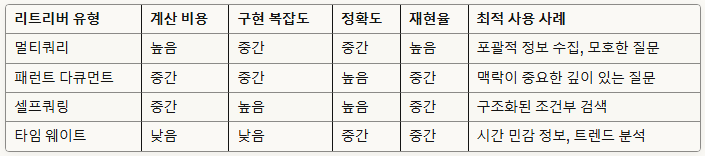